In [287]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb

import import_ipynb

import IPython

from pca import *
from prepare_data import *
from plot_figures import *
from NNpythorch import *
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Input Data**
* Data stored in a csv file are stored in a dataframe

In [288]:
cars = pd.read_csv(r'C:\Users\margh\OneDrive\Documenti\GIT\Marketing_Analytics\car_data.csv')
cars.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### **Exploratory Data Analysis**
* The analysis report presents that the DataFrame has 11914 rows and each row represents one car. The DataFrame has 16 features, 8 of which are catergorical. Engine Fuel Type, Engine HP, Engine Cylinders, Number of Doors, Market Category present missing values.

In [289]:
#@ Exploratory Data Analysis:
cars.info()                  # Inspecting the DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

**Market category**
* This column includes a list of elements
* it is transformed in severla columns, one for each element

In [290]:
mc = cars['Market Category'].str.get_dummies(',')
c_0 =cars.drop('Market Category', axis = 1)
cars_1 = pd.concat([c_0, mc], axis=1)
cars_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Vehicle Size       11914 non-null  object 
 10  Vehicle Style      11914 non-null  object 
 11  highway MPG        11914 non-null  int64  
 12  city mpg           11914 non-null  int64  
 13  Popularity         11914 non-null  int64  
 14  MSRP               11914 non-null  int64  
 15  Crossover          11914 non-null  int64  
 16  Diesel             119

### **Number of Doors**
* There is clearly a different definition for the number of doors, so I changed 3 to 2 for coherence

In [291]:
cars_1[cars_1['Number of Doors'] == 3]['Number of Doors']=2


### **Fill Nan**
* Engine Fuel Type: only 3 are missing, so I fill with the average value of the same make and model, which is constant
* Missing vlues for electric cars are averaged over electric cars only
* Flex fuel with gas is the average of the same mKE/MODEL/YEAR

In [293]:

fill_mode = lambda g:g.fillna(g.value_counts().idxmax()[0])
cars_1[['Engine Fuel Type']] = cars_1[['Engine Fuel Type']].groupby([cars_1['Make'],cars_1['Model']]).apply(fill_mode)

fill_mean = lambda g: g.fillna(round(g.mean()))
cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars_1['Make'],cars_1['Model'],cars_1['Year'],cars_1['Engine Fuel Type']]).apply(fill_mean)
cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars_1['Make'],cars_1['Model'],cars_1['Engine Fuel Type']]).apply(fill_mean)
cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars_1['Engine Fuel Type']]).apply(fill_mean)
cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars_1[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars_1['Make'],cars_1['Model'],cars_1['Year']]).apply(fill_mean)
cars_1[['Number of Doors' ]] = cars_1[['Number of Doors']].groupby([cars_1['Make'],cars_1['Model'],cars_1['Year']]).apply(fill_mean)
cars_1[['Number of Doors' ]] = cars_1[['Number of Doors']].groupby([cars_1['Make'],cars_1['Model']]).apply(fill_mean)

cars_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11914 non-null  object 
 4   Engine HP          11914 non-null  float64
 5   Engine Cylinders   11914 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11913 non-null  float64
 9   Vehicle Size       11914 non-null  object 
 10  Vehicle Style      11914 non-null  object 
 11  highway MPG        11914 non-null  int64  
 12  city mpg           11914 non-null  int64  
 13  Popularity         11914 non-null  int64  
 14  MSRP               11914 non-null  int64  
 15  Crossover          11914 non-null  int64  
 16  Diesel             119

### **Outliers**
* I checked the outliers are removed a sample with a mistype ( I could have fixed but I did not see the point)

In [303]:
# See if there is any outliers

# select columns to plot
df_to_plot = cars_1#.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)
# subplots
df_to_plot.plot(subplots=True, layout=(5,4), kind='box', figsize=(12,14), patch_artist=True)
plt.suptitle('Find Outliers', fontsize=15, y=0.9)
plt.savefig('boxplots.png', bbox_inches='tight')



In [ ]:
cars_1 = cars_1.drop(cars_1[cars_1['highway MPG']>200].index)

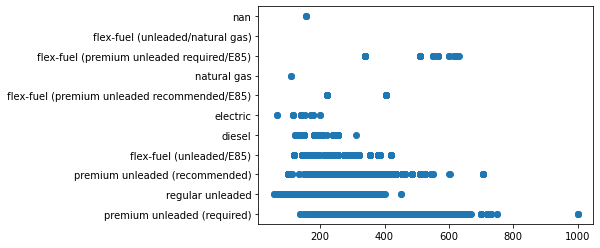

In [145]:

import matplotlib.pyplot as plt
plt.scatter( cars["Engine HP"],cars["Engine Fuel Type"].astype(str))

In [135]:
ecars = cars_1[cars_1['Engine Fuel Type']=='electric']
fcars = cars_1[cars_1['Engine Fuel Type']!='electric']

ecars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 539 to 9872
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               66 non-null     object 
 1   Model              66 non-null     object 
 2   Year               66 non-null     int64  
 3   Engine Fuel Type   66 non-null     object 
 4   Engine HP          22 non-null     float64
 5   Engine Cylinders   56 non-null     float64
 6   Transmission Type  66 non-null     object 
 7   Driven_Wheels      66 non-null     object 
 8   Number of Doors    61 non-null     float64
 9   Vehicle Size       66 non-null     object 
 10  Vehicle Style      66 non-null     object 
 11  highway MPG        66 non-null     int64  
 12  city mpg           66 non-null     int64  
 13  Popularity         66 non-null     int64  
 14  MSRP               66 non-null     int64  
 15  Crossover          66 non-null     int64  
 16  Diesel             66 no

In [136]:

fcars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11848 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11848 non-null  object 
 1   Model              11848 non-null  object 
 2   Year               11848 non-null  int64  
 3   Engine Fuel Type   11845 non-null  object 
 4   Engine HP          11823 non-null  float64
 5   Engine Cylinders   11828 non-null  float64
 6   Transmission Type  11848 non-null  object 
 7   Driven_Wheels      11848 non-null  object 
 8   Number of Doors    11847 non-null  float64
 9   Vehicle Size       11848 non-null  object 
 10  Vehicle Style      11848 non-null  object 
 11  highway MPG        11848 non-null  int64  
 12  city mpg           11848 non-null  int64  
 13  Popularity         11848 non-null  int64  
 14  MSRP               11848 non-null  int64  
 15  Crossover          11848 non-null  int64  
 16  Diesel             118

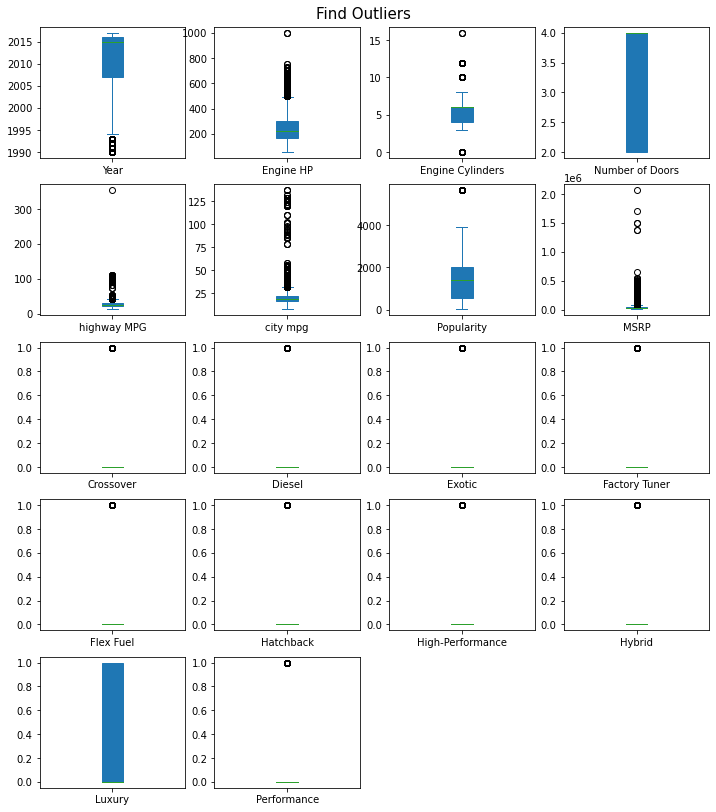

In [86]:

cars_oh = pd.get_dummies(cars)
cars_oh.head()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP,Make_Acura,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,Make_BMW,Make_Bentley,Make_Bugatti,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ferrari,Make_Ford,Make_GMC,Make_Genesis,Make_HUMMER,Make_Honda,Make_Hyundai,Make_Infiniti,Make_Kia,Make_Lamborghini,Make_Land Rover,Make_Lexus,Make_Lincoln,Make_Lotus,Make_Maserati,Make_Maybach,Make_Mazda,Make_McLaren,Make_Mercedes-Benz,Make_Mitsubishi,Make_Nissan,Make_Oldsmobile,Make_Plymouth,Make_Pontiac,Make_Porsche,Make_Rolls-Royce,Make_Saab,Make_Scion,Make_Spyker,Make_Subaru,Make_Suzuki,Make_Tesla,Make_Toyota,Make_Volkswagen,Make_Volvo,Model_1 Series,Model_1 Series M,Model_100,Model_124 Spider,Model_190-Class,Model_2,Model_2 Series,Model_200,Model_200SX,Model_240,Model_240SX,Model_3,Model_3 Series,Model_3 Series Gran Turismo,Model_300,Model_300-Class,Model_3000GT,Model_300M,Model_300ZX,Model_323,Model_350-Class,Model_350Z,Model_360,Model_370Z,Model_4 Series,Model_4 Series Gran Coupe,Model_400-Class,Model_420-Class,Model_456M,Model_458 Italia,Model_4C,Model_4Runner,Model_5,Model_5 Series,Model_5 Series Gran Turismo,Model_500,Model_500-Class,Model_500L,Model_500X,Model_500e,Model_550,Model_560-Class,Model_57,Model_570S,Model_575M,Model_599,Model_6,Model_6 Series,Model_6 Series Gran Coupe,Model_600-Class,Model_6000,Model_612 Scaglietti,Model_62,Model_626,Model_650S Coupe,Model_650S Spider,Model_7 Series,Model_718 Cayman,Model_740,Model_760,Model_780,Model_8 Series,Model_80,Model_850,Model_86,Model_9-2X,Model_9-3,Model_9-3 Griffin,Model_9-4X,Model_9-5,Model_9-7X,Model_90,Model_900,Model_9000,Model_911,Model_928,Model_929,Model_940,Model_944,Model_960,Model_968,Model_A3,Model_A4,Model_A4 allroad,Model_A5,Model_A6,Model_A7,Model_A8,Model_ALPINA B6 Gran Coupe,Model_ALPINA B7,Model_AMG GT,Model_ATS,Model_ATS Coupe,Model_ATS-V,Model_Acadia,Model_Acadia Limited,Model_Accent,Model_Acclaim,Model_Accord,Model_Accord Crosstour,Model_Accord Hybrid,Model_Accord Plug-In Hybrid,Model_Achieva,Model_ActiveHybrid 5,Model_ActiveHybrid 7,Model_ActiveHybrid X6,Model_Aerio,Model_Aerostar,Model_Alero,Model_Allante,Model_Alpina,Model_Altima,Model_Altima Hybrid,Model_Amanti,Model_Armada,Model_Arnage,Model_Aspen,Model_Aspire,Model_Astro,Model_Astro Cargo,Model_Aurora,Model_Avalanche,Model_Avalon,Model_Avalon Hybrid,Model_Avenger,Model_Aventador,Model_Aveo,Model_Aviator,Model_Axxess,Model_Azera,Model_Aztek,Model_Azure,Model_Azure T,Model_B-Class Electric Drive,Model_B-Series,Model_B-Series Pickup,Model_B-Series Truck,Model_B9 Tribeca,Model_BRZ,Model_Baja,Model_Beetle,Model_Beetle Convertible,Model_Beretta,Model_Black Diamond Avalanche,Model_Blackwood,Model_Blazer,Model_Bolt EV,Model_Bonneville,Model_Borrego,Model_Boxster,Model_Bravada,Model_Breeze,Model_Bronco,Model_Bronco II,Model_Brooklands,Model_Brougham,Model_C-Class,Model_C-Max Hybrid,Model_C/K 1500 Series,Model_C/K 2500 Series,Model_C30,Model_C36 AMG,Model_C43 AMG,Model_C70,Model_C8,Model_CC,Model_CL,Model_CL-Class,Model_CLA-Class,Model_CLK-Class,Model_CLS-Class,Model_CR-V,Model_CR-Z,Model_CT 200h,Model_CT6,Model_CTS,Model_CTS Coupe,Model_CTS Wagon,Model_CTS-V,Model_CTS-V Coupe,Model_CTS-V Wagon,Model_CX-3,Model_CX-5,Model_CX-7,Model_CX-9,Model_Cabrio,Model_Cabriolet,Model_Cadenza,Model_Caliber,Model_California,Model_California T,Model_Camaro,Model_Camry,Model_Camry Hybrid,Model_Camry Solara,Model_Canyon,Model_Caprice,Model_Captiva Sport,Model_Caravan,Model_Carrera GT,Model_Cascada,Model_Catera,Model_Cavalier,Model_Cayenne,Model_Cayman,Model_Cayman S,Model_Celebrity,Model_Celica,Model_Century,Model_Challenger,Model_Charger,Model_Chevy Van,Model_Ciera,Model_Cirrus,Model_City Express,Model_Civic,Model_Civic CRX,Model_Civic del Sol,Model_Classic,Model_Cobalt,Model_Colorado,Model_Colt,Model_Concorde,Model_Continental,Model_Continental Flying Spur,Model_Continental Flying Spur Speed,Model_Continental GT,Model_Continental GT Speed,Model_Continental G

In [77]:
#cars['Market Category'] = cars['Market Category'].apply(separate_list)


In [80]:
IPython.display.display(cars.describe())

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


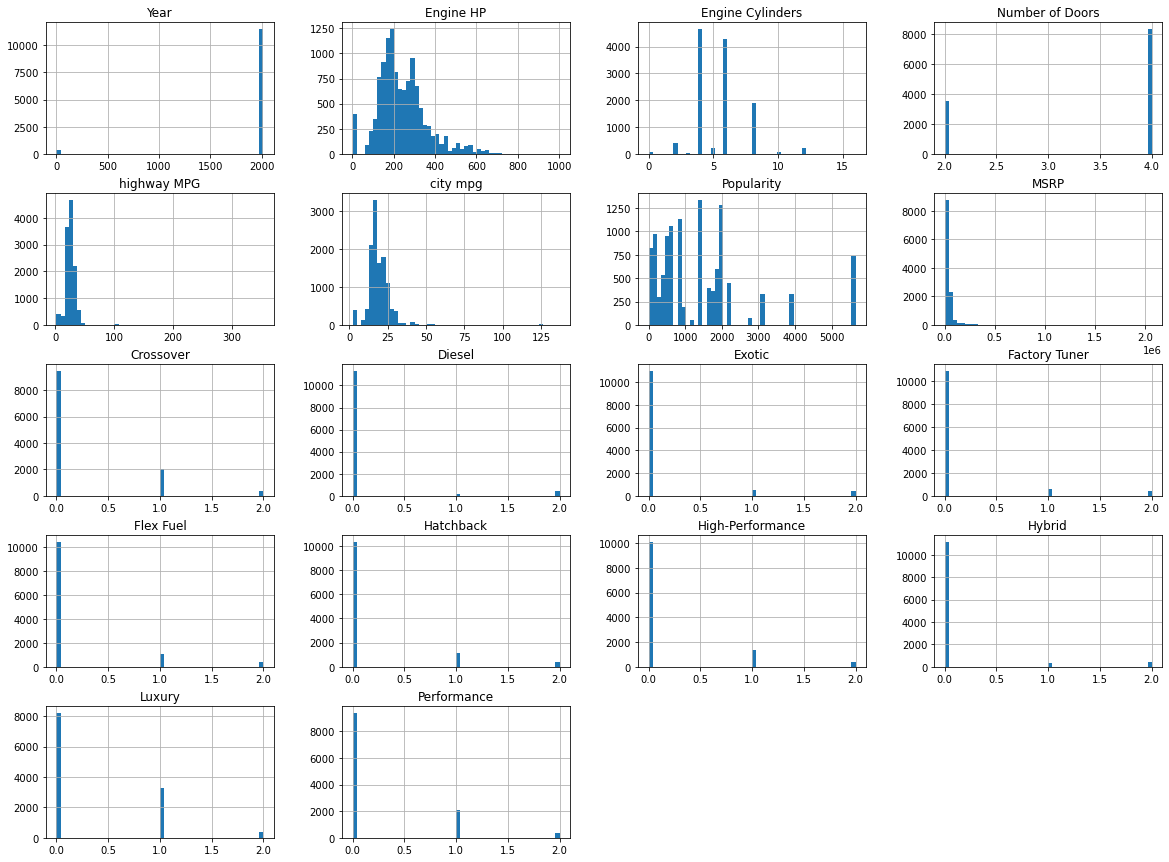

In [138]:
#@ Inspecting the Data using Histograms:
%matplotlib inline
import matplotlib.pyplot as plt
cars_1.hist(bins=50, figsize=(20, 15))   
plt.show() 

**Processing the Data**
* The whole dataset will be difided randomly between train (60%), validation and test sets (20% each).

In [82]:
#@ Splitting the Dataset:
from sklearn.model_selection import train_test_split
train_val_set, test_set = train_test_split(cars, test_size=0.2, random_state=11)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=11)